<a href="https://colab.research.google.com/github/Magrad/Progetto-Data_Intensive/blob/master/Progetto_Data_Intensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto: Digit recognition
**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Andrea Micheli
`andrea.micheli3@studio.unibo.it` 
matr. 000843618

## Setup

- Installare le seguenti librerie necessarie al funzionamento del progetto, in caso non siano già presenti sul sistema:
    - **Tensorflow** utilizzato come backend per la computazione da utilizzare attraverso Keras.
    - **Wget** utilizzato per ottenere FILES/DIR dal Web.

In [ ]:
%pip install tensorflow
%pip install wget

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf

- È consigliato eseguire il seguente progetto utilizzando la GPU per accelerare i tempi di training.
- Eseguire il seguente comando per accertarsi che la GPU sia vista correttamente.
    
    `es. ['/device:CPU:0', '/device:GPU:0']`

In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


- Librerie di uso comune necessarie alla rappresentazione o caricamento dei dati

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Descrizione del problema

- ## Obiettivo: Classificare correttamente numeri scritti a mano
    - Si vuole realizzare una NN in grado di classificare automaticamente numeri scritti a mano, con la percentuale di errore più bassa possibile.
    - MNIST (Modified National Institute of Standards and Technology) è un database nel quale sono presenti 60000 esempi di training e 10000 esempi di test da utilizzare per "allenare" e poi valutare il proprio modello.
    - Le immagini all'interno del MNIST sono rappresentazioni di cifre scritte a mano da studenti di scuole seperiori ed impiegati d'ufficio.
    - Le cifre presenti all'interno del MNIST vanno da 0 a 9.

# Funzioni utili per la raccolta dati

- **Download** utilizzato per scaricare FILE/DIR nella cartella corrente in caso non siano già presenti.

In [ ]:
def download(file, url):
    import os
    import wget
    
    # controlla se il file/dir è già presente all'interno della cartella corrente
    if not os.path.isfile(file):
        # scarica il file/dir richiesta dall'URL specificato
        wget.download(url+file)

- **Remove** utilizzato per eliminare i FILE/DIR una volta generato il file .csv.

In [ ]:
def remove(file):
    import os
    
    # controlla se nella cartella corrente esiste il file
    # che si vuole eliminare
    if os.path.exists(file):
        # rimuove file
        os.remove(file)

- **Unzip** utilizzato per decomprimere i quattro insiemi del MNIST.

In [ ]:
def unzip(file, file_type, nth):
    import gzip
    import shutil
    
    # rimuove l'estensione della cartella compressa
    file_name = file.split(".")[0]
    # aggiorna il file name con il tipo di estensione del file corrente
    file_name = file_name.replace('-', ".", nth)
    file_name = file_name.replace('.', "-", nth-1)
    
    # decomprime la cartella e copia il suo contenuto nella cartella corrente
    with gzip.open(file, 'rb') as f_in:
        with open(file_name, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    return file_name

- **Convert** utilizzato per convertire i file .idx3-ubyte del dataset in file .csv.

In [ ]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    # ricopia riga per riga tutte le immagini presenti nel dataset
    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close() 

- **MNIST_CSV** utilizza tutte le funzioni precedentemente definite. Se all'interno della cartella corrente non sono presenti i file .csv del training e validation set, la funzione seguente scarica, decomprime e genera i file necessari all'utilizzo dei dati tramite pandas.

In [ ]:
def mnist_csv(file_images, file_labels, url, csv_name, size, file_type, rmv):    
    import os
    
    # controlla se il file .csv che vuole essere
    # generato esiste già nella cartella corrente
    if not os.path.isfile(csv_name):
        # scarica il set di immagini
        download(file_images, url)
        # scarica il set di label di ogni immagine
        download(file_labels, url)
        file_name_images = unzip(file_images, file_type, 2)
        file_name_labels = unzip(file_labels, file_type, 2)
        # concatena il set di immagini e label in un singolo file .csv
        convert(file_name_images, file_name_labels, csv_name, size)
        if rmv:
            remove(file_images)
            remove(file_labels)
            remove(file_name_images)
            remove(file_name_labels)
        

- Vengono scaricati gli insiemi di train e test del MNIST e poi generati i relativi .csv.

In [ ]:
url = "http://yann.lecun.com/exdb/mnist/"
file_type = '.idx3-ubyte'
train_images = "train-images-idx3-ubyte.gz"
train_labels = "train-labels-idx1-ubyte.gz"
test_images = "t10k-images-idx3-ubyte.gz"
test_labels = "t10k-labels-idx1-ubyte.gz"
mnist_train = "mnist_train.csv"
mnist_test = "mnist_test.csv"

mnist_csv(train_images, train_labels, url, mnist_train, 60000, file_type, rmv=True)
mnist_csv(test_images, test_labels, url, mnist_test, 10000, file_type, rmv=True)

## Analisi esplorativa dei dati
- Generati i file .csv è possibile accedere ai dati utilizzando Pandas.

In [ ]:
train_set = pd.read_csv(mnist_train, header=None)
val_set = pd.read_csv(mnist_test, header=None)
train_set.columns = val_set.columns = ["label"] + [f"pixel_{x}" for x in range(train_set.shape[1]-1)]

- È ora possibile visualizzare le dimensioni dei due dataset.

In [ ]:
print("Size of training data: ", train_set.shape)
print("Size of test data: ", val_set.shape)

Size of training data:  (60000, 785)
Size of test data:  (10000, 785)


- Pandas facilita la rappresentazione dei dati sotto forma di tabelle.
- La colonna **label**, la prima colonna della tabella, rappresenta la corretta classificazione del numero rappresentato sotto forma di immagine.
- Le restanti 784 colonne rappresentano il valore di ogni pixel (da 0 a 255, da nero a bianco rispettivamente) di una immagine 28x28 pixel.

In [ ]:
train_set.head(10)

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
val_set.head(10)

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Le immagini all'interno del MNIST vengono, per lo più, centrate all'interno della matrice di pixel 28x28.
- Per poter meglio analizzare l'intervallo di numeri che ogni pixel può rappresentare, è quindi necessario osservare colonne centrali.

In [ ]:
train_set.iloc[:,160:210].head(8)

,pixel_159,pixel_160,pixel_161,pixel_162,pixel_163,pixel_164,pixel_165,pixel_166,pixel_167,pixel_168,...,pixel_199,pixel_200,pixel_201,pixel_202,pixel_203,pixel_204,pixel_205,pixel_206,pixel_207,pixel_208
0,26,166,255,247,127,0,0,0,0,0,...,0,0,0,0,49,238,253,253,253,253
1,237,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,60
2,0,67,232,39,0,0,0,0,0,0,...,0,126,163,0,0,0,0,0,0,0
3,253,255,63,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,55
5,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,40,152
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,144
7,253,174,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,178,252,252,252


- Visualizziamo la distribuzione dei valori suddivisi in classi.

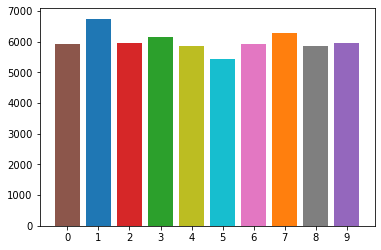

In [ ]:
counts = train_set["label"].value_counts()
label = []

for i in range(len(counts.index)):
    # aggiungiamo una nuova barra
    plt.bar(counts.index[i], counts.values[i])

    # aggiungiamo l'indice corrente
    label.append(i)
    plt.xticks(range(len(label)), labels=label)
plt.show()

- Per poter rappresentare i numeri sotto forma di immagini è necessaria una rimodellazione dei dati.
- Ogni riga del dataset viene rimodellata in una matrice 28 pixel x 28 pixel.
- Fatto ciò è possibile visualizzare l'immagine relativa ad ogni riga presente all'interno del MNIST database.

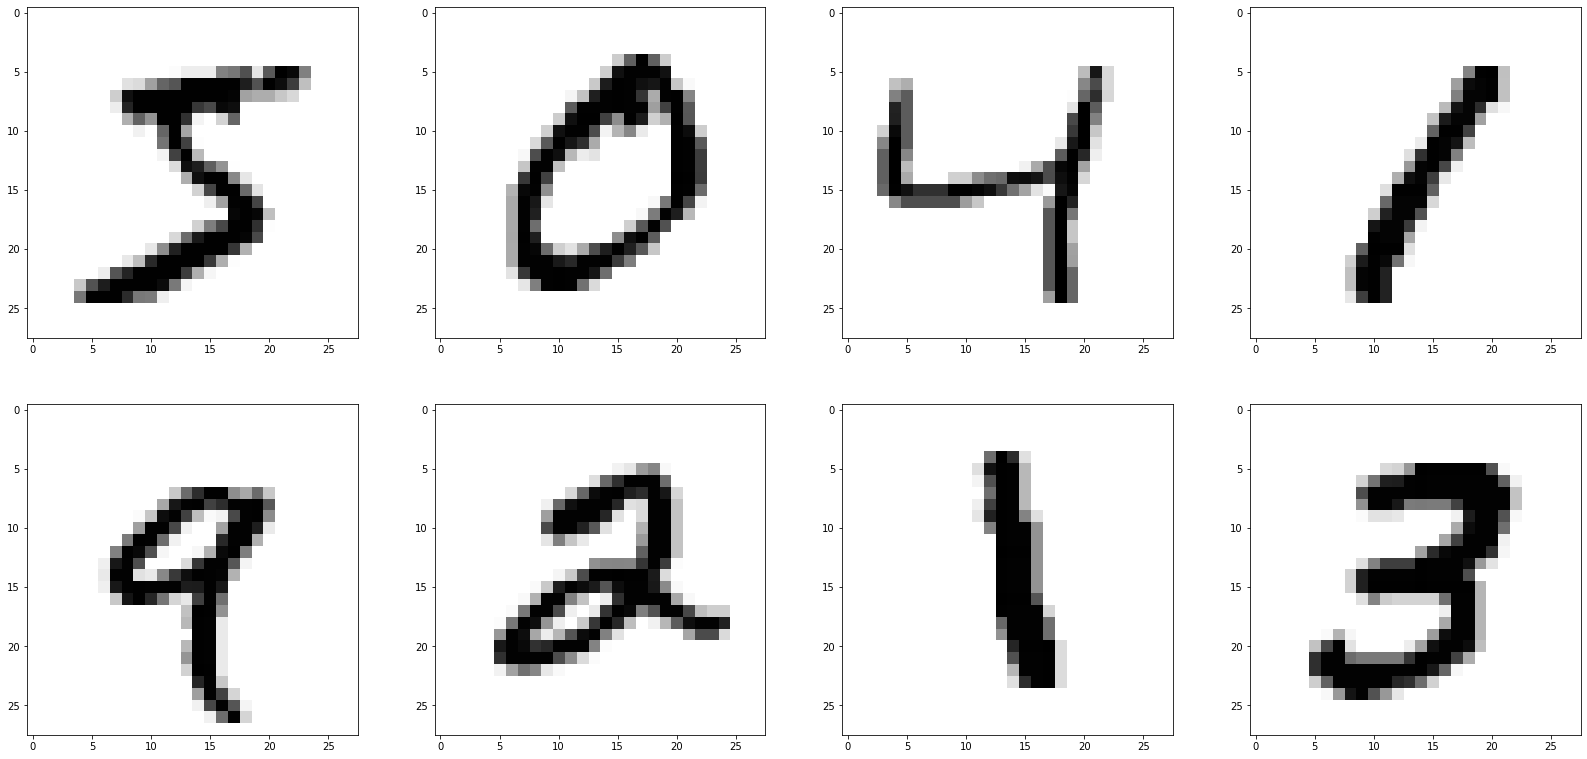

In [ ]:
plt.figure(figsize=(28, 28))
# mostriamo sono i primi 8 numeri presenti nel dataset
for x in range(8):
    # dimensione massima del subplot 4x4 (16 numeri rappresentabili al massimo)
    plt.subplot(4, 4, x+1)
    plt.imshow(np.reshape(train_set.iloc[x, 1:].to_numpy(), (28,28)), cmap=plt.cm.binary);
plt.show()

## Suddivisione dei dati
- Nel caso del MNIST database non è necessaria la separazione tra insiemei di training e di test in quanto i due set vengono già forniti separatamente.
- Selezionare i dati su cui lavorare:
    - la variabile `X_train` contiene i valore di tutti i pixel che formano l'immagine.
    - la variabile `y_train` da predirre è il numero rappresentato nell'immagine (da 0 a 9).

In [ ]:
X_train = train_set.drop(labels = ["label"], axis = 1)
y_train = train_set["label"]

In [ ]:
# viene scelta una sezione centrale per mostrare
# meglio la normalizzazione che verrà eseguita
X_train.iloc[:,160:210].head(8)

,pixel_160,pixel_161,pixel_162,pixel_163,pixel_164,pixel_165,pixel_166,pixel_167,pixel_168,pixel_169,...,pixel_200,pixel_201,pixel_202,pixel_203,pixel_204,pixel_205,pixel_206,pixel_207,pixel_208,pixel_209
0,166,255,247,127,0,0,0,0,0,0,...,0,0,0,49,238,253,253,253,253,253
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,60,224
2,67,232,39,0,0,0,0,0,0,0,...,126,163,0,0,0,0,0,0,0,0
3,255,63,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,55,148
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,40,152,244
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,144,253
7,174,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,178,252,252,252,252


In [ ]:
y_train.head(8)

0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
Name: label, dtype: int64

## Normalizzazione dei dati
- Per quale motivo è necessaria la normalizzazione del valore di ogni pixel?
    
    - Per aiutare a capire la necessità di una normalizzazione dei valori ho utilizzato la libreria Seaborn.
    - Utilizzando la funzione heatmap della libreria è possibile visualizzare il valore di ogni pixel dell'immagine.

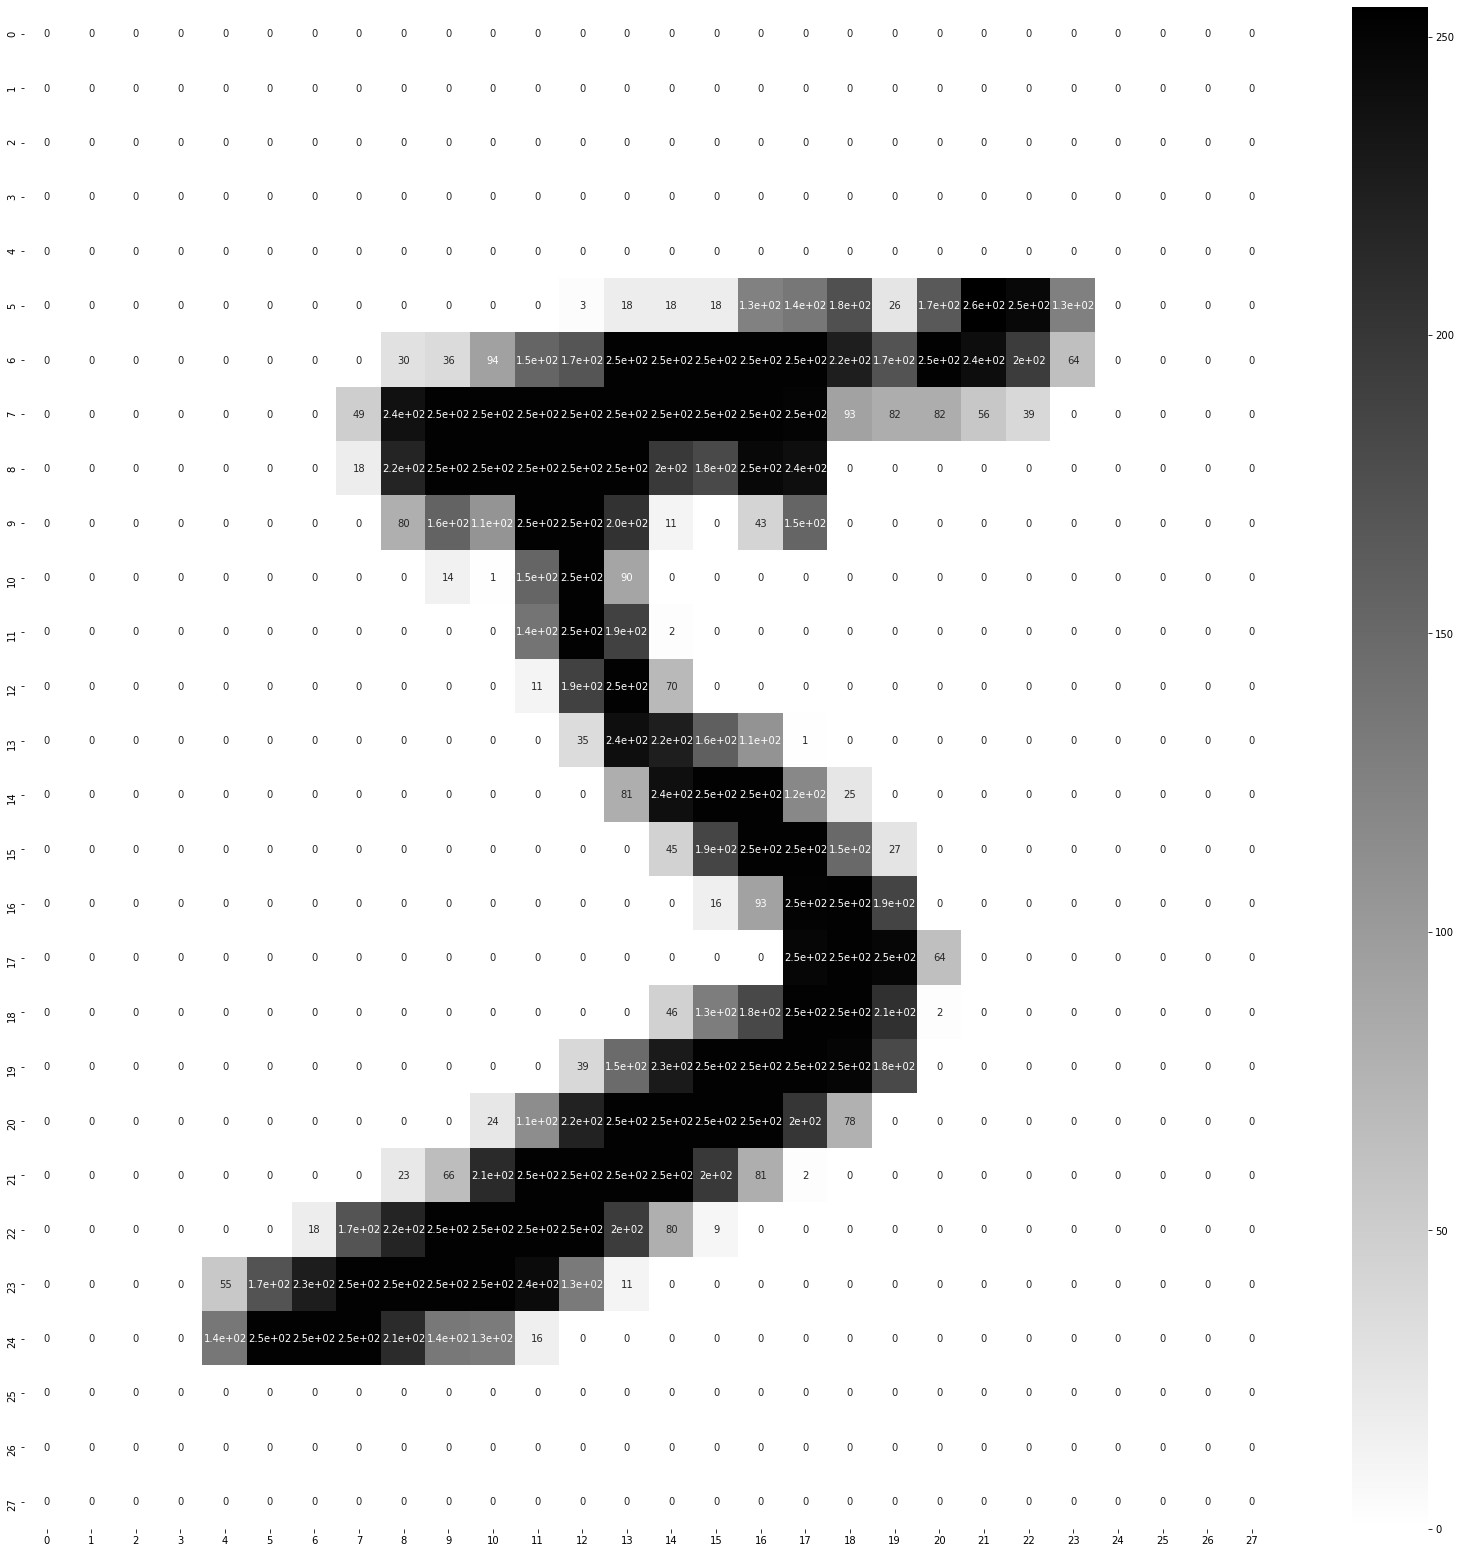

In [ ]:
import seaborn as sns
plt.figure(figsize=(28, 28))
sns.heatmap(np.reshape(X_train.iloc[0, :].to_numpy(), (28, 28)), annot=True, cmap="binary");

- Essendo ogni pixel un valore compreso tra 0 e 255, per normalizzare i nostri dati, sarà quindi necessario dividere ogni singolo valore per 255.
- Questo passaggio viene eseguito perchè, valori di grandi dimensioni, potrebbero rendere la computazione della NN più complicata.

In [ ]:
X_train = X_train / 255.0

- Come si può osservare di seguito, eseguita la normalizzazione, i valori di ogni pixel sono compresi tra 0 e 1.

In [ ]:
# viene scelta una sezione centrale per mostrare
# meglio la normalizzazione eseguita
X_train.iloc[:,160:210].head(8)

,pixel_160,pixel_161,pixel_162,pixel_163,pixel_164,pixel_165,pixel_166,pixel_167,pixel_168,pixel_169,...,pixel_200,pixel_201,pixel_202,pixel_203,pixel_204,pixel_205,pixel_206,pixel_207,pixel_208,pixel_209
0,0.650980,1.000000,0.968627,0.498039,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.192157,0.933333,0.992157,0.992157,0.992157,0.992157,0.992157
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.039216,0.235294,0.878431
2,0.262745,0.909804,0.152941,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.494118,0.639216,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.000000,0.247059,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.215686,0.580392
5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.156863,0.596078,0.956863
6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.564706,0.992157
7,0.682353,0.023529,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.698039,0.988235,0.988235,0.988235,0.988235


- Analiziamo nuovamente l'heatmap fornita da Seaborn, per visualizzare le modifiche apportate ai dati.

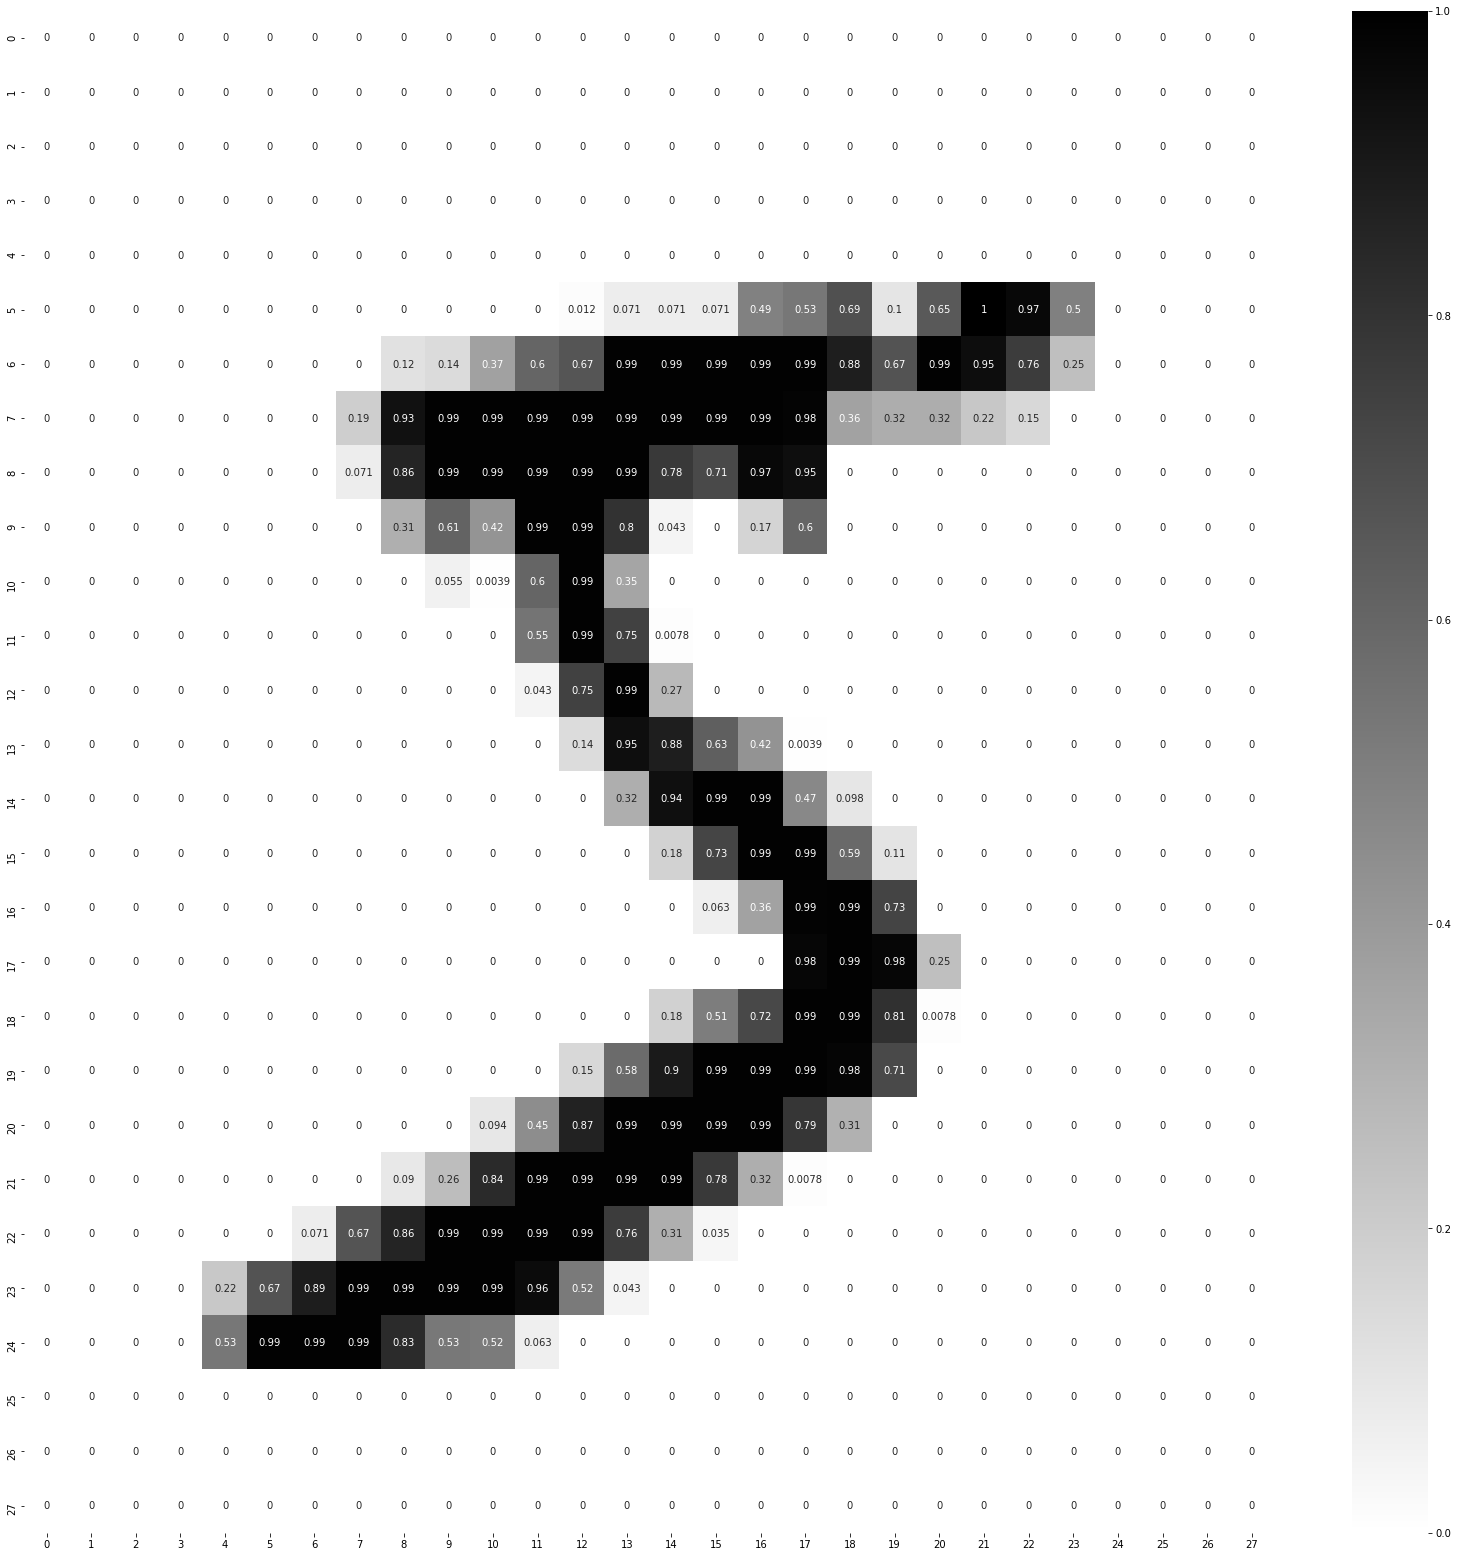

In [ ]:
plt.figure(figsize=(28, 28))
sns.heatmap(np.reshape(X_train.iloc[0, :].to_numpy(), (28, 28)), annot=True, cmap="binary");

- Eseguiamo le stesse operazioni sull'insieme di test.

In [ ]:
X_val = val_set.drop(labels = ["label"], axis = 1)
y_val = val_set["label"]

In [ ]:
X_val = X_val / 255.0

In [ ]:
X_val.head(8)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_val.head(8)

0    7
1    2
2    1
3    0
4    4
5    1
6    4
7    9
Name: label, dtype: int64

## Rete neurale di classificazione
- Si vuole addestrare un modello di classificazione in grado di distinguere le configurazioni di pixel che formano ogni numero da 0 a 9.
- Per poter generare la rete neurale ho usato un modello di Keras demonimato `Sequential`.
- Il modello `Sequential` permette di aggiungere semplicemente strato su strato: ciascuno ha esattamente un input **tensor** e un ouput **tensor**.

In [ ]:
from tensorflow.keras.models import Sequential

model = Sequential()

- ## Strato Dense
    - **Dense** è uno degli strati più utilizzati delle reti neurali.
    - Le operazioni che esegue questo strato sono:
    
        `output = activation(dot(input, kernel) + bias)`
        
    dove activation è la funzione eseguita elemento per elemento, kernel una matrice di pesi creati dallo strato e bias il vettore di pesi creati dallo strato (applicabile se `use_bias` è True).
    - Inoltre sul primo strato **Dense** bisogna indicare con `input_dim` il numero di valori in input.
    - Per creare uno strato **Dense** bisogna specificare il numero nodi di output e la funzione di attivazione da utilizzare, cioè `activation`.

In [ ]:
from tensorflow.keras.layers import Dense

model.add(Dense(10, activation="softmax", input_dim=X_train.shape[1]))

- La funzione di attivazione `softmax` converte un vettore di valori in una distribuzione di probabilità, utile per determinare quale sia il numero che, in questo caso, la rete neurale pensa sia rappresentato nell'immagine.

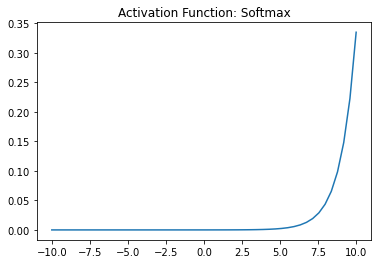

In [ ]:
def softmax_visualizer(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

x = np.linspace(-10, 10)
plt.plot(x, softmax_visualizer(x))
plt.axis('tight')
plt.title('Activation Function: Softmax')
plt.show()

- Per poter visualizzare il riepilogo della rete neurale si può utilizzare la funzione `summary` di Keras, la quale mostra la configurazione strato per strato.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


- Per compilare il modello è necessario specificare quali metriche sia necessario utilizzare per poter giudicarne le prestazioni.
- È necessario specificare:
    - l'algoritmo di ottimizzazione da utilizzare. 
    - la misura d'errore.
    - la metrica dell'errore da ottimizzare.

- Per questo progetto ho utilizzato `Adam` (metodo di discesa del gradiente stocastico) come algoritmo di ottimizzazione, `Sparse Categorical Crossentropy` (utilizzata quando sono presenti due o più classi da classificare) come misura d'errore e in aggiunta si vuole mostrare anche l'accuratezza del modello.
    

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

- Viene addestrato il modello per 5 epoche su `X_train` e `y_train`.

In [ ]:
fit_history = model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 1ms/step - loss: 0.4692 - accuracy: 0.8777
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3041 - accuracy: 0.9153
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2834 - accuracy: 0.9208
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2734 - accuracy: 0.9241
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2664 - accuracy: 0.9269


La funzione **plot_loss_accuracy** serve per visualizzare la rappresentazione su grafico delle variabili di `loss` e `accuracy` ad ogni epoca.

In [ ]:
def plot_loss_accuracy(model_history):
    plt.plot(model_history.history["loss"], "ro-")
    plt.plot(model_history.history["accuracy"], "bo-")
    plt.legend(["Loss", "Accuracy"])
    plt.xlabel("Epochs");

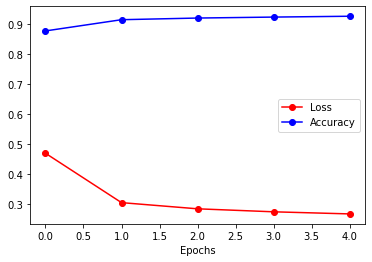

In [ ]:
plot_loss_accuracy(fit_history)

- Tramite la funzione `predict` di **Keras** è possibile generare un vettore di probabilità per ogni immagine da classificare.

In [ ]:
y_pred = model.predict(X_val)

313/313 [==============================] - 0s 640us/step


- La funzione `evaluate` permette di ottenere il valore di loss e l'accuratezza del modello sui dati di test.

In [ ]:
model.evaluate(X_val, y_val)

313/313 [==============================] - 0s 1ms/step - loss: 0.2656 - accuracy: 0.9271


[0.26555007696151733, 0.9271000027656555]

La funzione **display_errors** permette di visualizzare in quali casi la rete neurale abbia sbagliato la classificazione dell'immagine. Oltre a mostrare la figura del numero errato, presnta, sotto forma di titolo, la relativa etichetta predetta e quella reale.

In [ ]:
def display_errors(label_set, predictions, n):
    x = 0; y = 0
    cols = round(n/2)
    rows = round(n/cols)
    _, axs = plt.subplots(rows, cols, sharex=True, sharey=True,constrained_layout=True)
    for e in range(len(predictions)):
        if y >= rows:
            return
        if np.argmax(predictions[e]) != label_set[e]:
            axs[y,x].imshow(np.reshape(val_set.iloc[:, 1:].to_numpy()[e], (28,28)), cmap=plt.cm.binary)
            axs[y,x].set_title("Predicted label:{}\nTrue label:{}".format(np.argmax(predictions[e]), label_set[e]))
            x = 0 if x == cols-1 else x+1
            y = y+1 if x == 0 else y

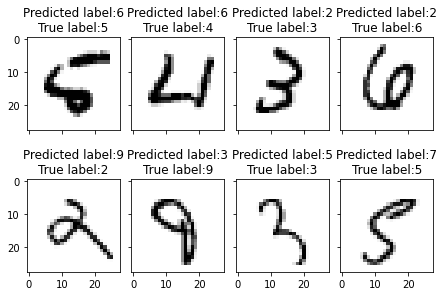

In [ ]:
display_errors(y_val, y_pred, 8)
plt.show();

- Eseguiamo ora una rimodellazione dei dati, traformando ogni riga in una matrice quadrata.
- In questo modo `X_train` non sarà più accessibile come un DataFrame Pandas, ma sarà possibile utilizzare altri strati di **Keras**, più appropriati al nostro tipo di input.

In [ ]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28, 28, 1)
img_dim = X_train.shape[1]

- ## Strato Flatten
    - Lo strato `Flatten` permette di convertire l'input ed "appiattirlo", rimodellandolo in un array monodimensionale.
    - In questo modo è possibile aggiornare il modello, affiché sia conforme alla nuova forma dell'input.

In [ ]:
from tensorflow.keras.layers import Flatten

model = Sequential([
    Flatten(input_shape=(img_dim, img_dim, 1)),
    Dense(10, activation="softmax") 
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

- Rieseguiamo ora i test per verificare che il modello ottenga più o meno lo stesso risultato.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fit_history = model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4699 - accuracy: 0.8778
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3044 - accuracy: 0.9149
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2835 - accuracy: 0.9205
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2732 - accuracy: 0.9244
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2666 - accuracy: 0.9255


In [ ]:
model.evaluate(X_val, y_val)

313/313 [==============================] - 0s 1ms/step - loss: 0.2699 - accuracy: 0.9251


[0.2698509097099304, 0.9251000285148621]

- ## Hidden Layers
    - Aggiungiamo ulteriori strati alla rete neurale, per migliorarne l'accuracy.
    - L'aggiunta di ulteriori strati permette alla rete neurale di rinoscere familiarità nei dati e di classificare correttamente dataset con correlazione tra i valori più complicate.

In [ ]:
model = Sequential([
    Flatten(input_shape=(img_dim, img_dim, 1)),
    Dense(32, activation="relu"),
    Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

- La funzione di attivazione **relu** controlla elemento per elemento: in caso il valore sia superiore a 0, rimane lo stesso, altrimenti viene impostato a 0.

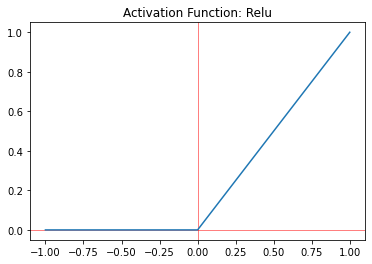

In [ ]:
def relu_visualizer(x):
    return np.maximum(0, x)

x = np.arange(-1, 1.1, 0.1)
y = [relu_visualizer(i) for i in x]
plt.axvline(x=0, color="red", linewidth=.5)
plt.axhline(y=0, color="red", linewidth=.5)
plt.title('Activation Function: Relu')
plt.plot(x, y)
plt.show()

- Si può osservare come il numero di parametri cresca drasticamente.
- Il numero totale di parametri del modello si può calcolare come:

    `n_params = input x layers_shape + layer_shape`

In [ ]:
784*32 + 32 + 32*10 + 10

25450

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fit_history = model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3443 - accuracy: 0.9042
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1833 - accuracy: 0.9477
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1483 - accuracy: 0.9575
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1257 - accuracy: 0.9625
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1100 - accuracy: 0.9677


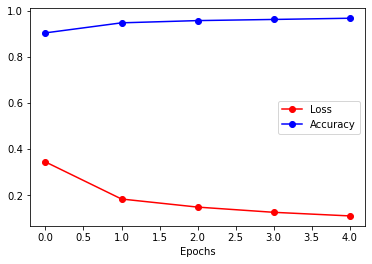

In [ ]:
plot_loss_accuracy(fit_history)

In [ ]:
model.evaluate(X_val, y_val)

313/313 [==============================] - 0s 1ms/step - loss: 0.1278 - accuracy: 0.9640


[0.1277984231710434, 0.9639999866485596]

- Con l'aggiunta di un ulteriore strato **Dense** l'architettura del modello corrente ha incrementato l'accuratezza rispetto al suo predecessore.
- Osserviamo i possibili nuovi casi in cui il modello compie errori di classificazione.

313/313 [==============================] - 0s 701us/step


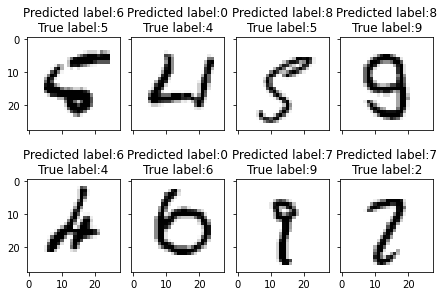

In [ ]:
y_pred = model.predict(X_val)

display_errors(y_val, y_pred, 8)
plt.show();

- ## Strato Dropout
    - È essenziale alle rete neurali in quanto previene overfitting.
    - Durante la fase di addestramento, con una frequenza `rate` (come mostrato nell'esempio successivo 0.25), ignora nodi della rete disattivando le connessioni in entrata o in uscita ad essi.
    - Gli strati di **Dropout** sono attivi solo durante la fase di training del modello.

In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Flatten(input_shape=(img_dim, img_dim, 1)),
    Dense(32, activation="relu"),
    Dropout(0.25),
    Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
fit_history = model.fit(X_train, y_train, epochs=15)

Epoch 1/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5268 - accuracy: 0.8419
Epoch 2/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3072 - accuracy: 0.9090
Epoch 3/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2673 - accuracy: 0.9203
Epoch 4/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2450 - accuracy: 0.9272
Epoch 5/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2287 - accuracy: 0.9309
Epoch 6/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2188 - accuracy: 0.9337
Epoch 7/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2103 - accuracy: 0.9360
Epoch 8/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2043 - accuracy: 0.9381
Epoch 9/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1965 - accuracy: 0.9390
Epoch 10/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.189

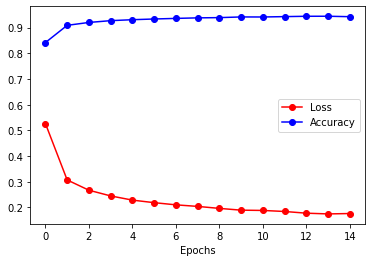

In [ ]:
plot_loss_accuracy(fit_history)

- Come si può notare dai dati di loss ed accuracy sopra riportati, la fase di training è terminata con un valore di accuratezza inferiore rispetto al modello precente, pur avendo allenato il modello per più epoche.
- A differenza del valore di accuratezza ottenuto sull'input di training, quella riportata sul set di validazione, risulta superiore al modello precedente.

In [ ]:
model.evaluate(X_val, y_val)

313/313 [==============================] - 1s 1ms/step - loss: 0.1306 - accuracy: 0.9633


[0.13055264949798584, 0.9632999897003174]

- ## Reti Convoluzionali
    - Per poter riconoscere pattern all'interno di immagini, indipendemente dal punto in cui si trovano, si utilizzano reti convoluzionali.
    - I primi strati convoluzionali permettono di identificare caratteristiche all'interno del set di immagini, che vengono date come training al modello. Man mano che i dati in input proseguono all'interno della rete neurale, i pattern diventano sempre più esclusivi.
    - Nel mio caso l'utilizzo di strati convoluzionali permette alla rete neurale di identificate componenti che formano la rappresentazione grafica del numero.
    - I modelli di reti convoluzionali sono progettati per funzionare con immagini come input, ma possono anche fungere da input monodimensioni e tridimensionali.
    

- ## Strato Conv2D
    - Lo strato **Conv2D** esegue una moltiplicazione, elemento per elemento, tra una sezione di dimensione `kernel_size` dell'input e `filter` (insieme di pesi).
    - La dimensione di `kernel_size` è volutamente più piccola dell'immagine di input: in questo modo è possibile applicare su diverse porzioni dell'immagine gli stessi pesi.
    - L'approccio di uno stesso insieme di pesi, che vengono utilizzati su tutta l'immagine, è importante per poter riscontrare le stesse caratteristiche in diverse sezioni di essa.
    - Riconoscere pattern senza preoccuparsi della loro posizione all'interno dell'immagine, permette alla rete neurale di aumentare drasticamente le sue prestazioni.

In [ ]:
from tensorflow.keras.layers import Conv2D

model = Sequential([
    Conv2D(filters=64, kernel_size=(5, 5), activation="relu", input_shape=(img_dim, img_dim, 1)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    Dropout(0.25),
    Flatten(),
    Dense(32, activation="relu"),
    Dropout(0.25),
    Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 dropout_2 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 30976)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                991264    
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [ ]:
fit_history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2242 - accuracy: 0.9335
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1019 - accuracy: 0.9694
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0754 - accuracy: 0.9777
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0651 - accuracy: 0.9798
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0534 - accuracy: 0.9838
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0477 - accuracy: 0.9848
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0432 - accuracy: 0.9870
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0380 - accuracy: 0.9875
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0359 - accuracy: 0.9882
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.033

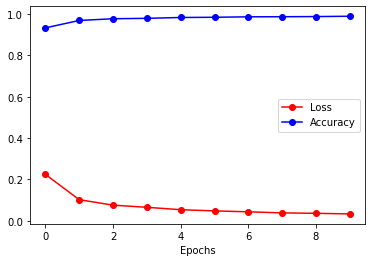

In [ ]:
plot_loss_accuracy(fit_history)

In [ ]:
model.evaluate(X_val, y_val)

313/313 [==============================] - 1s 2ms/step - loss: 0.0386 - accuracy: 0.9904


[0.03863911330699921, 0.9904000163078308]

In [ ]:
y_pred = model.predict(X_val)

313/313 [==============================] - 0s 1ms/step


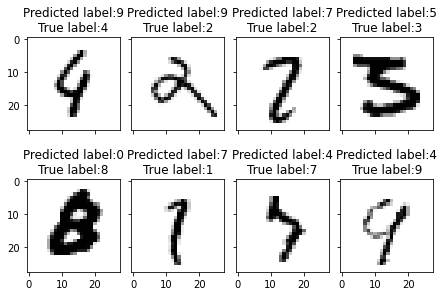

In [ ]:
display_errors(y_val, y_pred, 8)
plt.show();

- ## Strato MaxPooling
    - Per permettere alla rete convoluzionale di identificare le stesse caratteristiche, indipendentemente dalla loro posizione all'interno dell'immagine, si utilizzano strati di **Pooling**.
    - In modo simile agli strati **Conv2D**, anche **Pooling** utilizza un filtro di dimensioni prestabilite (nell'esempio successivo (2, 2)) che, posizionato sui valori in input ricevuti dallo strato di convoluzione, identifica, in questo caso, il maggiore tra i due valori e lo riporta in una mappa di output.
    - Tramite la variabile `strides` è possibile specificare la distanza per la quale il filtro si sposta.

In [ ]:
from tensorflow.keras.layers import MaxPooling2D

model = Sequential([
    Conv2D(filters=64, kernel_size=(5, 5), activation="relu", input_shape=(img_dim, img_dim, 1)),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(32, activation="relu"),
    Dropout(0.25),
    Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
fit_history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2354 - accuracy: 0.9282
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0996 - accuracy: 0.9698
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0759 - accuracy: 0.9767
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0628 - accuracy: 0.9804
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0556 - accuracy: 0.9830
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0466 - accuracy: 0.9847
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0411 - accuracy: 0.9865
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0394 - accuracy: 0.9874
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0338 - accuracy: 0.9895
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.033

In [ ]:
model.evaluate(X_val, y_val)

313/313 [==============================] - 1s 2ms/step - loss: 0.0351 - accuracy: 0.9919


[0.03505093604326248, 0.9919000267982483]

- ## Strato BatchNormalization
    - Questo strato permette di normalizzare l'input in arrivo ad un altro strato.
    - Normalizzare l'output di ogni strato aiuta rete neurali di grandi dimensioni nella computazione, diminuendo così il tempo richiesto per il training.

In [ ]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(filters=64, kernel_size=(5, 5), activation="relu", input_shape=(img_dim, img_dim, 1)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.25),
    Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                      

In [ ]:
fit_history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1525 - accuracy: 0.9588
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0639 - accuracy: 0.9811
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0509 - accuracy: 0.9849
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0417 - accuracy: 0.9872
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0370 - accuracy: 0.9884
Epoch 6/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0316 - accuracy: 0.9897
Epoch 7/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0279 - accuracy: 0.9912
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0246 - accuracy: 0.9921
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0230 - accuracy: 0.9928
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.019

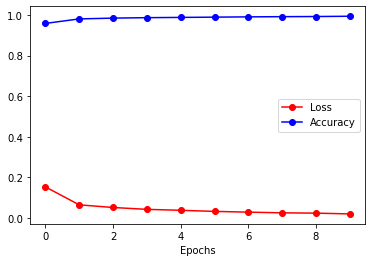

In [ ]:
plot_loss_accuracy(fit_history)

In [ ]:
model.evaluate(X_val, y_val)

313/313 [==============================] - 1s 2ms/step - loss: 0.0248 - accuracy: 0.9920


[0.024780577048659325, 0.9919999837875366]

In [ ]:
y_pred = model.predict(X_val)

313/313 [==============================] - 0s 1ms/step


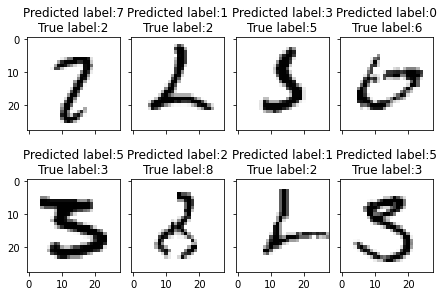

In [ ]:
display_errors(y_val, y_pred, 8)
plt.show();

## Keras Tuner

- Framework utile nella ricerca dei migliori iperparametri di una rete neurale.
- Facilita la ricerca di nuovi modelli, proponendo un'analisi per iterazioni delle migliori combinazioni di strati e relativi iperparametri.

In [ ]:
%pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in d:\anaconda3\lib\site-packages (1.1.2)
Note: you may need to restart the kernel to use updated packages.


- ## Costruzione del modello con Iperparametri
    - La costruzione di un modello di rete neurale è simile a quelle viste precedentemente.
    - Si decide quali parametri si vogliano cercare o quali strati aggiungere al modello.
    - Tramite l'utilizzo della variabile `hp` è possibile definire valori di diverso tipo: `Int`, `Float`, `Fixed`, `Boolean` e `Choice`, a seconda di ciò che si vuole ottimizzare.
    - Ad ogni `trial` verrà creato un nuovo modello, con valori tra l'intervallo selezionato.
    - Alla fine della ricerca sarà possibile visualizzare gli strati e i parametri di tutti i modelli testati.

In [ ]:
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation="relu", input_shape=(img_dim, img_dim, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation="relu"))
    model.add(BatchNormalization())
    
    for e in range(hp.Int("n_sequence", 1, 2)):
        for i in range(hp.Int("n_layers", 1, 2)):
            model.add(Conv2D(
                filters=hp.Int(f"conv_[{e},{i}]", min_value=64, max_value=128, step=32),
                kernel_size=(3, 3),
                padding='Same',
                activation="relu"))
            model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)) if e == 1 else MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
        model.add(Dropout(hp.Float(f"dropout_{e}", min_value=0.1, max_value=0.25, step=0.05)))
        
    model.add(Flatten())
    model.add(Dense(hp.Int(f"dense", min_value=64, max_value=256, step=64), activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_out", min_value=0.1, max_value=0.25, step=0.05)))
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model
    

- ## Ricerca del modello migliore

    - Una volta specificato il tipo di tuner (nel mio caso **RandomSearch**), è necessario specificare:
        - la funzione che restituirà il modello;
        - ll numero di differenti modelli da testare (`max_trials`);
        - ll numero di esecuzione dello stesso modello ad ogni passo;
        - la metrica dell'errore da ottimizzare (in questo caso `val_accuracy`, come nei modelli testati fino ad ora);
        - la cartella in cui saranno salvati tutti i modelli eseguiti.

In [ ]:
tuner = RandomSearch(
    build_model,
    objective = "val_accuracy",
    seed=42,
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_output',
    project_name="MNIST"
    )

- Per iniziare la ricerca è necessario, come per la funzione **fit** di keras, specificare:
    - le variabili di training;
    - la `batch_size`, numero di input da analizzare prima di cambiare i pesi;
    - le `epochs`, numero di epoche di training;
    - l'insieme di validazione dei dati.


In [ ]:
tuner.search(x=X_train,
             y=y_train,
             batch_size=128,
             epochs=8,
             validation_data=(X_val, y_val))

Trial 10 Complete [00h 01m 57s]
val_accuracy: 0.9941999912261963

Best val_accuracy So Far: 0.9947999715805054
Total elapsed time: 00h 16m 13s
INFO:tensorflow:Oracle triggered exit


- Per mostrare il risultato del miglior modello, **Keras Tuner** offre la lista di tutti i modelli testati in questa sessione.

In [ ]:
tuner.get_best_models()[0].evaluate(X_val, y_val)

313/313 [==============================] - 1s 4ms/step - loss: 0.0152 - accuracy: 0.9948


[0.015177389606833458, 0.9947999715805054]

## Conclusioni
- Utilizzando reti neurale di tipo convoluzionale è possibile classificare con un'accuratezza superiore al 99% l'insieme di immagini fornite nel MNIST.
- Servendomi di dati del 2018, trovati su Kaggle, il modello di CNN da me proposto, si posizionerebbe nella top 20-15% dei punteggi ottenuti.
- Un livello di accuratezza migliore si potrebbe ottenere con dataset specifici, che contengono più immagini rispetto a quello proposto dal MNIST.
- Si potrebbe ancora migliorare il modello testando ulteriormente altri iperparametri e strati utilizzando Keras Tuner.

- Una volta ottenuta un'ottima configurazione, è possibile salavare, tramite l'utilizzo della libreria **Pickle**, il `tuner`, contenente tutti i modelli testati.

In [ ]:
import pickle

In [ ]:
with open("tuner.bin", "wb") as f:
    pickle.dump(tuner, f);

- Per poter utilizzare un `tuner` salvato precedentemente, è necessario utilizzare **Pickle**, per caricare il file.

In [ ]:
with open("tuner.bin", "rb") as f:
    load_tuner = pickle.load(f)

- È possibile analizzare e valutare singolarmente ogni modello, contenuto nella sessione precedentemente eseguita.

In [ ]:
model = load_tuner.get_best_models()[0];

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 64)       2

In [ ]:
model.evaluate(X_val, y_val)

313/313 [==============================] - 1s 4ms/step - loss: 0.0152 - accuracy: 0.9948


[0.015177389606833458, 0.9947999715805054]

In [ ]:
y_pred = model.predict(X_val)

313/313 [==============================] - 1s 2ms/step


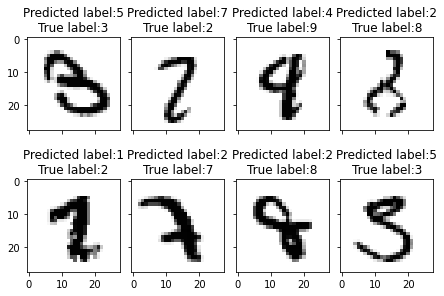

In [ ]:
display_errors(y_val, y_pred, 8)
plt.show();

- ## Fashion MNIST
    - Per interesse personale ho provato a testare la stessa architettura di rete neurale su un altro dataset che offre il MNIST.
    - Il Fashion MNIST propone un dataset di indumenti o accessori di moda.
    - In questo caso ho utilizzato, per comodità, il dataset che mette a disposizione **Keras**.

In [ ]:
fashion_data = tf.keras.datasets.fashion_mnist

(fashion_X_train, fashion_y_train), (fashion_X_val, fashion_y_val) = fashion_data.load_data()

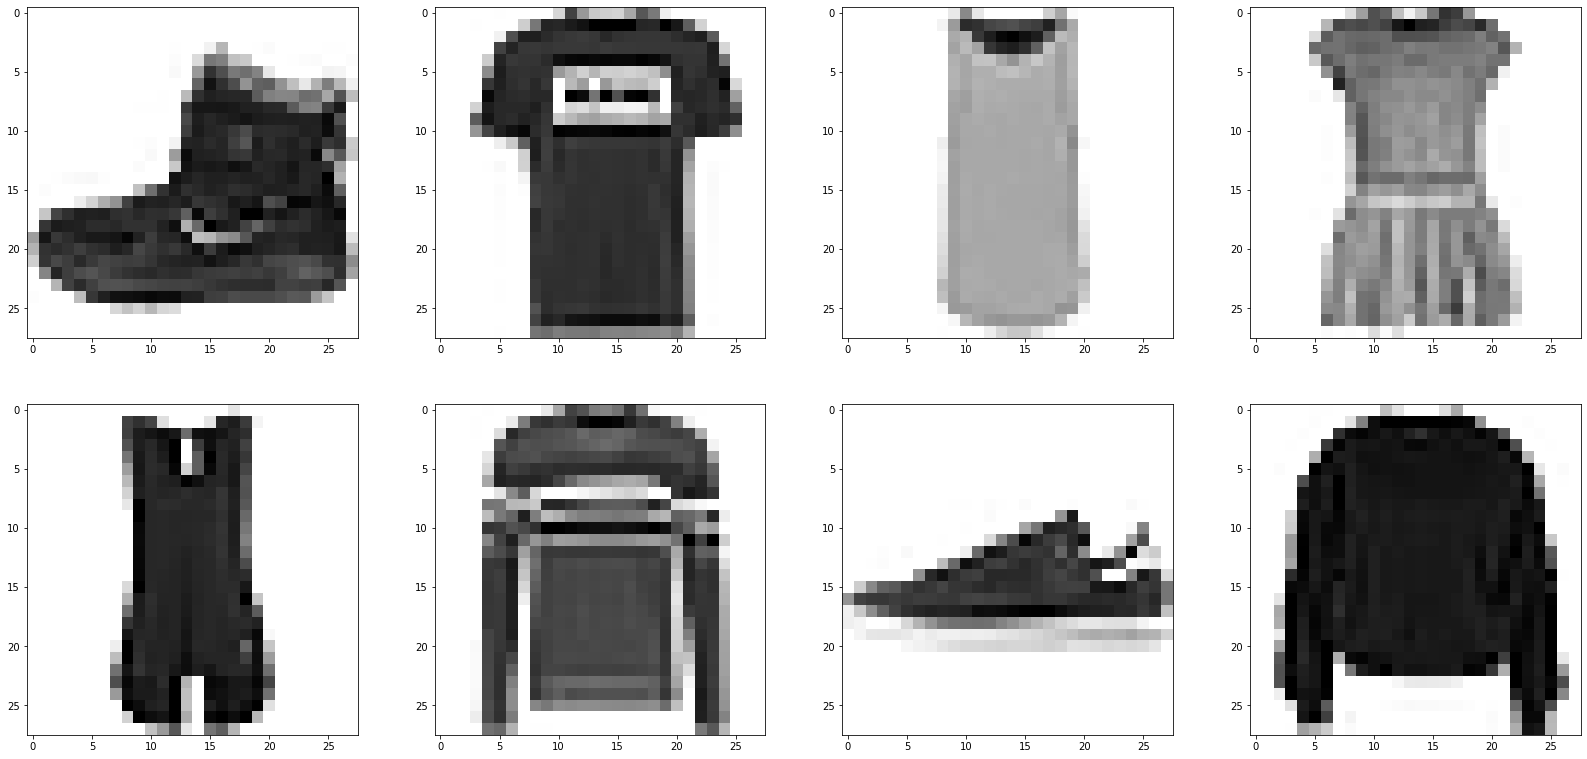

In [ ]:
plt.figure(figsize=(28, 28))
# mostriamo sono i primi 8 numeri presenti nel dataset
for x in range(8):
    # dimensione massima del subplot 4x4 (16 numeri rappresentabili al massimo)
    plt.subplot(4, 4, x+1)
    plt.imshow(fashion_X_train[x], cmap=plt.cm.binary);
plt.show()

- Applichiamo le stesse operazioni di normalizzazione dei dati.

In [ ]:
fashion_X_train = fashion_X_train / 255
fashion_X_val = fashion_X_val / 255

- Cloniamo la struttura della migliore rete convoluzionale proposta da **Keras Tuner**.

In [ ]:
fashion_model = tf.keras.models.clone_model(model)

In [ ]:
fashion_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
fashion_model.fit(fashion_X_train, fashion_y_train, batch_size=128, epochs=8, validation_data=(fashion_X_val, fashion_y_val))

Epoch 1/8
469/469 [==============================] - 10s 21ms/step - loss: 0.3812 - accuracy: 0.8627 - val_loss: 0.4592 - val_accuracy: 0.8450
Epoch 2/8
469/469 [==============================] - 11s 24ms/step - loss: 0.2470 - accuracy: 0.9096 - val_loss: 0.2561 - val_accuracy: 0.9058
Epoch 3/8
469/469 [==============================] - 10s 21ms/step - loss: 0.2124 - accuracy: 0.9215 - val_loss: 0.2621 - val_accuracy: 0.9008
Epoch 4/8
469/469 [==============================] - 9s 20ms/step - loss: 0.1829 - accuracy: 0.9334 - val_loss: 0.2295 - val_accuracy: 0.9165
Epoch 5/8
469/469 [==============================] - 9s 20ms/step - loss: 0.1635 - accuracy: 0.9408 - val_loss: 0.2098 - val_accuracy: 0.9218
Epoch 6/8
469/469 [==============================] - 9s 20ms/step - loss: 0.1458 - accuracy: 0.9450 - val_loss: 0.2273 - val_accuracy: 0.9255
Epoch 7/8
469/469 [==============================] - 10s 21ms/step - loss: 0.1319 - accuracy: 0.9513 - val_loss: 0.2245 - val_accuracy: 0.9200
Ep

- Anche con questo set di dati, otteniamo un ottimo risultato, tra il 15-10% delle reti convoluzionali proposte.